# Setup

In [1]:
# Add src/ folder to path
import sys
src_path = '../../code/' 
sys.path.insert(0, src_path) 

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns


from factor_scatter_matrix import factor_scatter_matrix
from IPython.display import display, HTML
from plot_confusion_matrix import plot_confusion_matrix
from mf import matrix_factorization
from sklearn.metrics import confusion_matrix

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# Matplotlib global settings
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14

In [4]:
data_df = pd.read_csv("../../data/raw/speed_dating_data.csv", encoding="ISO-8859-1")
HTML(data_df.head(5).to_html())

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,partner,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,undergra,mn_sat,tuition,race,imprace,imprelig,from,zipcode,income,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,dec,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,satis_2,length,numdat_2,attr7_2,sinc7_2,intel7_2,fun7_2,amb7_2,shar7_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr4_2,sinc4_2,intel4_2,fun4_2,amb4_2,shar4_2,attr2_2,sinc2_2,intel2_2,fun2_2,amb2_2,shar2_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,you_call,them_cal,date_3,numdat_3,num_in_3,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,1,11.0,0,0.14,0,27.0,2.0,35.0,20.0,20.0,20.0,0.0,5.0,0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,19.44,16.67,13.89,22.22,11.11,16.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,2,12.0,0,0.54,0,22.0,2.0,60.0,0.0,0.0,40.0,0.0,0.0,0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,19.44,16.67,13.89,22.22,11.11,16.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,3,13.0,1,0.16,1,22.0,4.0,19.0,18.0,19.0,18.0,14.0,12.0,1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,1.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,1,5.0,8.0,9.0,8.0,5.0,7.0,7.0,NaN,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,19.44,16.67,13.89,22.22,11.11,16.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,4,14.0,1,0.61,0,23.0,2.0,30.0,5.0,15.0,40.0,5.0,5.0,1,7.0,8.0,9.0,8.0,9

# Adjacency Matrix

In [46]:
df = data_df[['iid', 'pid', 'dec', 'gender']]

# remove rows where pid = NaN
df = df[~np.isnan(df['pid'])]

In [47]:
df.describe()

,iid,pid,dec,gender
count,8368.000000,8368.000000,8368.000000,8368.00000
mean,283.863767,283.863767,0.420053,0.50000
std,158.584899,158.584899,0.493597,0.50003
min,1.000000,1.000000,0.000000,0.00000
25%,154.000000,154.000000,0.000000,0.00000
50%,281.000000,281.000000,0.000000,0.50000
75%,408.000000,408.000000,1.000000,1.00000
max,552.000000,552.000000,1.000000,1.00000


In [48]:
df.head(5)

,iid,pid,dec,gender
0,1,11.0,1,0
1,1,12.0,1,0
2,1,13.0,1,0
3,1,14.0,1,0
4,1,15.0,1,0


In [11]:
n_ppl = np.max(df['iid'])
n_dates = df.shape[0]

print("Number of People:", n_ppl)
print("Number of Dates :", n_dates)

Number of People: 552
Number of Dates : 8368


In [12]:
def create_adj_matrix(df):
    adj = np.zeros((n_ppl, n_ppl))
    adj.fill(np.nan)
    
    for i in range(df.shape[0]):
        iid_idx = int(df.iloc[i,0] - 1)
        pid_idx = int(df.iloc[i,1] - 1)
        dec = df.iloc[i,2]
    
        if dec == 1:
            adj[iid_idx, pid_idx] = 1
        else:
            adj[iid_idx, pid_idx] = 0
        
    return adj

In [13]:
adj = create_adj_matrix(df)

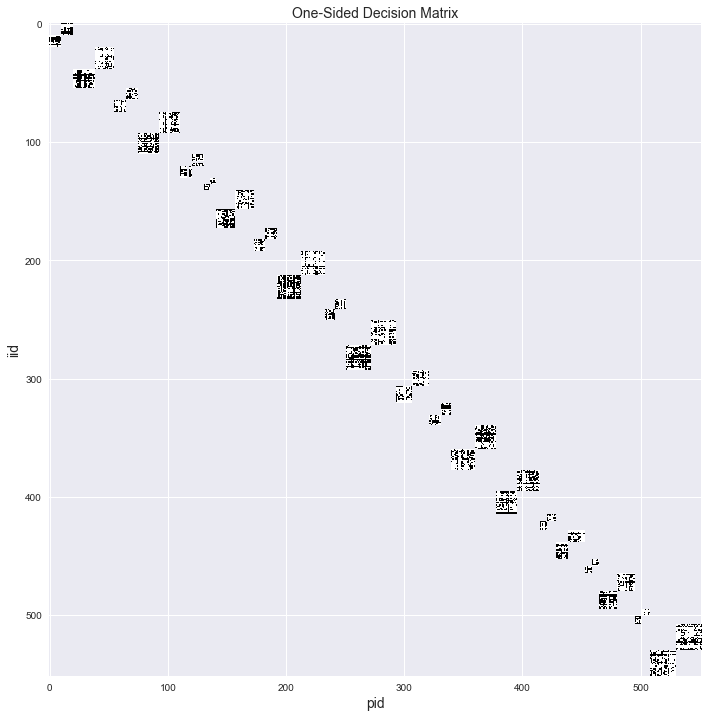

In [14]:
plt.figure(figsize=(12,12))
plt.imshow(adj)
plt.title("One-Sided Decision Matrix")
plt.xlabel("pid")
plt.ylabel("iid")
plt.show()

Male decisions: bottom-left corner of matrix  
Female decisions: top-right corner of matrix

# Train-Test Split

In [49]:
test_size = round(n_dates * .10)
test_idx = np.random.choice(np.arange(0,n_dates), size=test_size, replace=False)

In [64]:
test_idx = np.array([ 525, 2642, 4937, 7296, 7058, 3614,  241, 4862, 2761,  105, 6762,
       4825, 2764, 4611,  229, 3200, 4930,  384, 1822, 1505, 2159, 3484,
       5246, 1237, 5964,  929, 7704, 4606, 6928, 5823, 2402, 7502, 8188,
       6221, 4942, 8054, 3261,  277, 5339, 7781, 2248, 5650, 3479, 7903,
       2836,   47, 8230, 5713, 7518, 6159, 6376, 1397, 2408, 6052, 3906,
       1272, 6524, 7124, 2175, 5887, 3286,  745, 2699, 8213, 8124, 3596,
        727, 1230,  858, 6234, 1142, 2485, 8261, 1627,  213, 1416, 2388,
       3606, 3865, 5691, 7627,  292, 4592, 7869, 3481,   29, 8349, 1804,
       4052, 3138, 6330,  809, 4385, 2332,  275,  593, 3593, 1349, 5034,
        407, 4322, 2197, 5118,  881, 4821, 4183, 2702,  958, 1892, 5515,
       1895, 5814, 4250, 5359, 7164, 2156, 7885, 6186, 3690,  434, 6859,
       3352,   31, 4031, 3689, 6562,  199, 6125, 8026, 1170, 5592,  494,
       7432, 5930, 4272, 6357, 2208, 5852, 1829, 6583, 2339,  587, 8085,
       2160, 6459, 1141,  887, 1587,  665, 2610, 1003, 6780, 3103, 3835,
       6641,  389, 4620, 3192, 4583, 2094, 4978, 3329, 2888, 4725, 1109,
       6134, 5530, 7255, 3745, 3359, 2283, 7524, 1528, 8156, 5986, 8001,
       1265, 5659,   53, 1254, 7405,  193, 2066,  718,  868, 5506, 2956,
       6973, 4022, 5370, 2667, 4109, 6495, 3005, 8150,  185, 2059, 5649,
       5325, 2995, 5418, 1898,  280, 6870, 7090, 3285, 2269, 2095, 1015,
       2648, 6292, 1714, 7545, 7091, 4258, 6206, 2405, 1719, 7981, 8041,
       1740, 2205, 6559, 2881, 6884, 2259, 6198, 3424, 2885, 2650,  788,
       7365, 6089, 6608, 5052, 1180, 6397, 7740, 7989, 7591,  742, 7184,
       4553, 2641, 2795, 6143, 5985, 6299, 1103, 4603, 5881, 4873, 3078,
       2400, 8366, 5601, 1322, 7898, 3387, 1178, 4860, 2255, 4955, 3345,
       2279,  455, 6944, 6030, 7688, 4637, 5241, 8164, 4148, 5197, 1398,
       7171, 6153,  360, 3411, 1421, 6317, 7880, 2383, 3589, 8077, 7941,
       2038,  816, 4576, 1678, 2336, 4585, 6185, 3760, 4124, 5658, 2720,
       7373, 3025, 1043, 2150, 6521, 5132, 7543, 3080, 7221, 3785, 6155,
       6916, 4048, 5845,  125, 3796, 6478, 2292, 6417, 6395, 5616, 4959,
       5861, 2909, 1574, 6348, 4917, 5299, 3684, 1708, 4280, 8049, 6302,
       3238, 4509, 4388, 8135, 6550,  446, 3236, 1851, 3637, 5419, 6385,
       6821, 8129, 5896,  169, 1255, 2466, 4434, 3615,  884, 1654, 2070,
       5011, 6816, 5240, 4944, 2415, 5703, 2058, 5423, 6313, 5994, 4153,
       2775, 1389, 3607, 4871, 5773,  112, 7741, 7942, 7035, 6644,  212,
       7572, 3366, 7894, 3102, 5663, 5381, 3276, 1339, 2063,  870, 2067,
        226, 2001, 7857, 1818, 7660, 4763, 1470, 3893,  510, 3284,  271,
       4923, 5889, 6729, 2767, 4546, 2420,  453, 5394, 4114, 7520, 1538,
       7742, 3205, 8098, 7038, 1319, 7821, 3874, 5511,  178, 1486, 6879,
       4762, 4976,  833, 6462, 1366, 6177, 2639, 2295,  147,  177, 2608,
       1159, 5508, 8266,   63, 4009, 3137, 6214, 5604, 5340, 6826, 4441,
       3854, 6372, 3210,  103, 3465, 3355, 3552, 5862, 3474, 1021,   95,
       5268, 3340, 6481, 5927, 2658, 3826, 1510, 5448, 3094, 6873, 4407,
       1545, 5811,  173, 4845, 6055, 2271, 2843, 7382, 2393, 8071, 2549,
        950, 5893, 1495, 7696, 1073, 2355,  798,  626, 4919, 2162, 7060,
       1645, 6157, 8122, 6662, 3169, 4471, 8167, 4503, 7673, 3176, 5290,
       5683, 4474, 6240, 2040,  735, 7463, 4166, 5690,  794, 8339,   41,
       2654, 5498, 4062, 4689, 6318,  667, 5961, 7043, 4101, 1665,  746,
       2796, 3488, 4215, 1168,   17, 3545, 2774, 4248, 3616, 1946,  819,
       3648,   82, 5839,  775, 2960, 5909, 3010, 3956, 4628, 8045, 1506,
       2217, 7481, 4103, 5157, 1457, 7093, 7618, 1722, 2963, 3578, 1774,
       1011, 7358, 1136, 1064,  166, 6226, 2762,   79, 2167, 3412, 5715,
       2788, 8262, 7908, 5705,  863, 1783,  371, 1873, 2640, 5684, 5415,
       7513,  569, 7042,  934, 5224,  265, 2460, 6640, 2584, 3277,  851,
       6325, 4449, 7750, 7770, 3825,  683, 7640, 5633, 6596, 6315, 6941,
       2049, 4706, 2481, 4941, 3246,  284, 2625, 6815, 6360,  209, 8116,
       1813, 6010, 6546, 2980,  449, 1222, 4814, 4678, 5451, 5145, 8285,
       1635, 2721, 6502, 6113, 5305, 4068, 1084,  748,  701, 6135, 7873,
        770, 5069, 5330,  717, 4569, 5937, 6404, 7938, 7585, 7909, 4700,
       6548, 5821, 3499, 2675, 7041, 3714, 7299, 7605, 1744, 6371, 3805,
       6038, 3730, 2722, 2190, 6432, 3249, 7072, 3890, 2858, 7682, 5103,
         34, 4366, 4745, 2317,  823, 4616, 6671,  937, 8317, 8141,  939,
       2797, 4649, 5560, 5435, 4848, 2036, 2816, 3768, 3003, 4267, 2828,
       4601, 1704, 7045, 8117, 1687, 1508, 1435, 2199, 4974, 1600, 3136,
       7391, 1107, 3948, 2506, 7139, 1793, 3087, 2500, 2740, 6857, 5645,
       3375, 3852, 5520,   18, 2526, 2877, 8048, 5395, 1847, 1235, 2905,
       6896,  907, 4982,  997, 1399, 1020, 7226, 5593, 3735, 5207, 7778,
       4024, 7791, 7350, 2508,    2, 1854, 7799, 4329, 4754, 3656, 4396,
       6247, 5055, 7723, 7813, 3942, 4076, 5509, 8046, 2863, 7005, 3172,
        821, 6797, 7242, 5131, 1840, 2328, 7434,  474, 4903,  750, 8151,
       6956, 5447, 1984, 6838, 6669, 1691, 3469, 5119,  296, 3014, 3152,
       1204, 1674, 7055, 2444, 7936, 4106, 4358, 6105, 8358, 6694,   54,
       1242, 1057, 3602, 7884, 1639, 4711, 1521, 3957,  942,  951, 1496,
       3485, 2034, 6154, 1338, 5922, 7917, 7644, 7552, 2455, 5065, 2024,
       7057, 5309, 7904, 5384, 4461, 7551, 5546, 6848, 4686, 7282, 7468,
        920, 1451, 6311, 8345, 8105, 3445, 7311, 3446, 4802, 6868, 7815,
       6244, 2421, 4654, 3519, 1653, 1943, 5853, 7801, 8022, 5837, 4781,
       4977])

In [50]:
train_df = df.drop(df.index[test_idx])
test_df  = df.iloc[test_idx,:]

In [60]:
adj_train = create_adj_matrix(train_df)
adj_test  = create_adj_matrix(test_df)

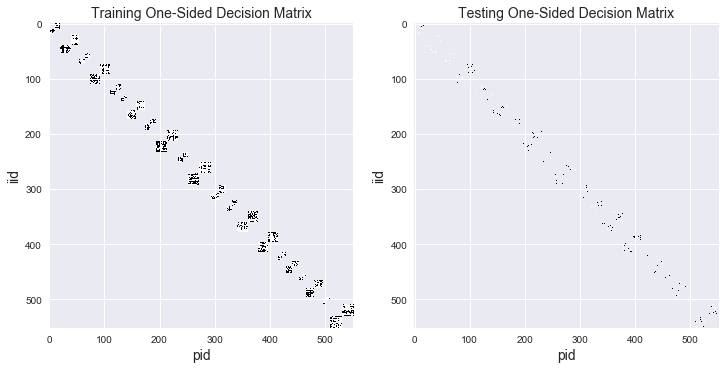

In [61]:
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(adj_train)
plt.title("Training One-Sided Decision Matrix")
plt.xlabel("pid")
plt.ylabel("iid")

plt.subplot(1,2,2)
plt.imshow(adj_test)
plt.title("Testing One-Sided Decision Matrix")
plt.xlabel("pid")
plt.ylabel("iid")
plt.show()

# Baseline Models

## Predict Average

In [51]:
avg_dec = np.mean(train_df['dec'])
print("Train Rate of Acceptance:", round(avg_dec,2))
print("Most Likely Decision:", 0)

Train Rate of Acceptance: 0.42
Most Likely Decision: 0


In [52]:
print("Test Accuracy Rate:", round(np.mean(test_df['dec'] == 0),2))

Test Accuracy Rate: 0.59


## Predict Average for Gender

In [58]:
avg_dec_m = np.mean(train_df.loc[train_df['gender'] == 1, 'dec'])
avg_dec_f = np.mean(train_df.loc[train_df['gender'] == 0, 'dec'])

print("Male Train Rate of Acceptance:", round(avg_dec_m,2))
print("Female Train Rate of Acceptance:", round(avg_dec_f,2))
print("Most Likely Decision for both Genders:", 0)

Male Train Rate of Acceptance: 0.48
Female Train Rate of Acceptance: 0.36
Most Likely Decision for both Genders: 0


In [52]:
print("Test Accuracy Rate:", round(np.mean(test_df['dec'] == 0),2))

Test Accuracy Rate: 0.59


## Jacard Similarity

In [59]:
from sklearn.metrics.pairwise import cosine_similarity

In [62]:
cosine_similarity(adj_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# Matrix Factorization

In [69]:
R = adj_train
N = len(R)
M = len(R[0])
K = 2

P = np.random.rand(N,K)
Q = np.random.rand(M,K)

In [70]:
# warm start initialization
P = np.loadtxt("../../models/mf/P.txt", delimiter=',')
Q = np.loadtxt("../../models/mf/Q.txt", delimiter=',')

In [71]:
nP, nQ = matrix_factorization(R, P, Q, K, verbose=0)